# Predicting the number of rebar in an image
After training the model, we can use it to predict the number of rebar in an image.

In [2]:
import os
import torch
import torchvision
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DetrForObjectDetection, DetrFeatureExtractor
from sklearn.metrics import mean_squared_error

## Load the model
We will use the model trained in the previous notebook. We need to load it as well as sprecifying the architecture of the model.

In [3]:
# Create the Data loader to train the model
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, mode='train'):
        assert mode in ['train', 'val', 'test'],  f'Unknown mode: {mode}'
        ann_file = os.path.join(img_folder, f"annotations/{mode}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


# We define our model based on DETR
class Detr(pl.LightningModule):

     def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, num_queries=500, num_labels=2, pretrained_model="facebook/detr-resnet-50"):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained(pretrained_model, 
                                                             num_labels=num_labels,
                                                             num_queries=num_queries,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer
     # This part is not needed since we are not training the model
     # 
     # def train_dataloader(self):
     #    return train_dataloader
     # 
     # def val_dataloader(self):
     #    return val_dataloader

In [4]:
# Read the model from file
model1 = Detr
model = Detr.load_from_checkpoint("./model/detr.ckpt")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Set up the device
model.to(device)
model.eval()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [5]:
# Set up pre-trained model
pretrained_model = "facebook/detr-resnet-50"
img_folder = "RebarDSC/images"

feature_extractor = DetrFeatureExtractor.from_pretrained(pretrained_model)
val_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='val')
test_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='test')

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


## Hyperparameter tuning
Since the model is taking more than 3 hours to train, we will use the validation set to perform a parameter tuning on the threshold to get the best MSE.
This is a good practice to avoid overfitting the test set, and also a good compromise between the time spent training and the accuracy of the model.

In [6]:
def count_rebar(outputs, threshold=0.7):
  # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

  # return the count of rebar
    return len(probas[keep])

In [7]:
# Perform a parameter tuning on the threshold to get the best MSE
def get_RMSE(threshold, mode="val"):
    pred_res = pd.DataFrame(columns=["image_id", "pred_count", "act_count"])
    if mode == "val":
        dataset = val_dataset
    elif mode == "test":
        dataset = test_dataset
    else:
        raise ValueError("Unknown mode")
    
    for it in iter(range(len(dataset))):
        if it % 20 == 0:
            # Print the progress
            print(f'{it}/{len(dataset)}')

        pixel_values, target = dataset[it]
        act_count = target['class_labels'].sum().tolist()
        
        pixel_values = pixel_values.unsqueeze(0).to(device)
        outputs = model(pixel_values=pixel_values, pixel_mask=None)
        image_id = target['image_id'].item()
        pred_count = count_rebar(outputs, threshold=threshold)
        
        pred_res.loc[len(pred_res)] = [image_id, pred_count, act_count]
        
    return mean_squared_error(pred_res["act_count"], pred_res["pred_count"]), pred_res

In [8]:
# Perform a parameter tuning on the threshold to get the best MSE
thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
RMSEs = []
for threshold in thresholds:
    RMSE = get_RMSE(threshold, mode="val")[0]
    print(f"Threshold: {threshold}, RMSE: {RMSE}")
    RMSEs.append(RMSE)

0/225
20/225
40/225
60/225
80/225
100/225
120/225
140/225
160/225
180/225
200/225
220/225
Threshold: 0.5, RMSE: 108905.2
0/225
20/225
40/225
60/225
80/225
100/225
120/225
140/225
160/225
180/225
200/225
220/225
Threshold: 0.6, RMSE: 93260.42222222222
0/225
20/225
40/225
60/225
80/225
100/225
120/225
140/225
160/225
180/225
200/225
220/225
Threshold: 0.7, RMSE: 67846.43111111112
0/225
20/225
40/225
60/225
80/225
100/225
120/225
140/225
160/225
180/225
200/225
220/225
Threshold: 0.8, RMSE: 33583.497777777775
0/225
20/225
40/225
60/225
80/225
100/225
120/225
140/225
160/225
180/225
200/225
220/225
Threshold: 0.9, RMSE: 9478.36


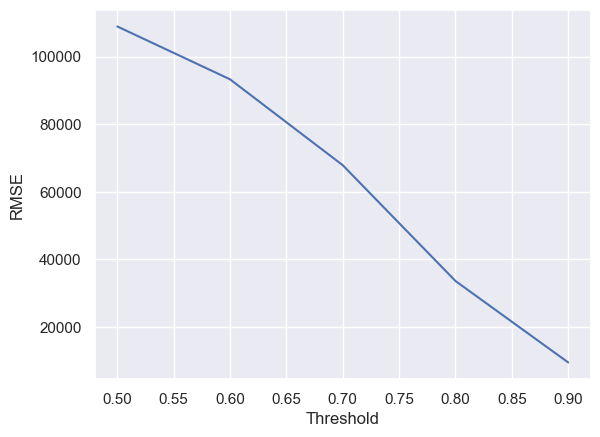

In [9]:
#Visualize the results
sns.set()
plt.plot(thresholds, RMSEs)
plt.xlabel("Threshold")
plt.ylabel("RMSE")
plt.show()

In [10]:
# Find the best threshold
best_threshold = thresholds[RMSEs.index(min(RMSEs))]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.9


In [ ]:
# Get the MSE (Mean Squared Error)
results = get_RMSE(best_threshold, mode="test")
print("MSE:", results[0])

0/1000
20/1000
40/1000
60/1000
80/1000
100/1000
120/1000
140/1000
160/1000
180/1000
200/1000
220/1000


In [ ]:
# Compare the MSE to a naive model
avg_count = results[1]["act_count"].mean()
print("MSE naive:", mean_squared_error(results[1]["act_count"], [avg_count]*len(results[1])))